<a href="https://colab.research.google.com/github/Psevdopolughirnikot/-ITC-MTPBN-/blob/main/%D0%93%D1%80%D0%B0%D1%84%D0%B8%D0%BA%D0%B8_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B_%D0%B8%D0%BD%D0%B3%D0%B8%D0%B1%D0%B8%D1%82%D0%BE%D1%80%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ГРАФИКИ РАБОТЫ ИНГИБИТОРОВ**
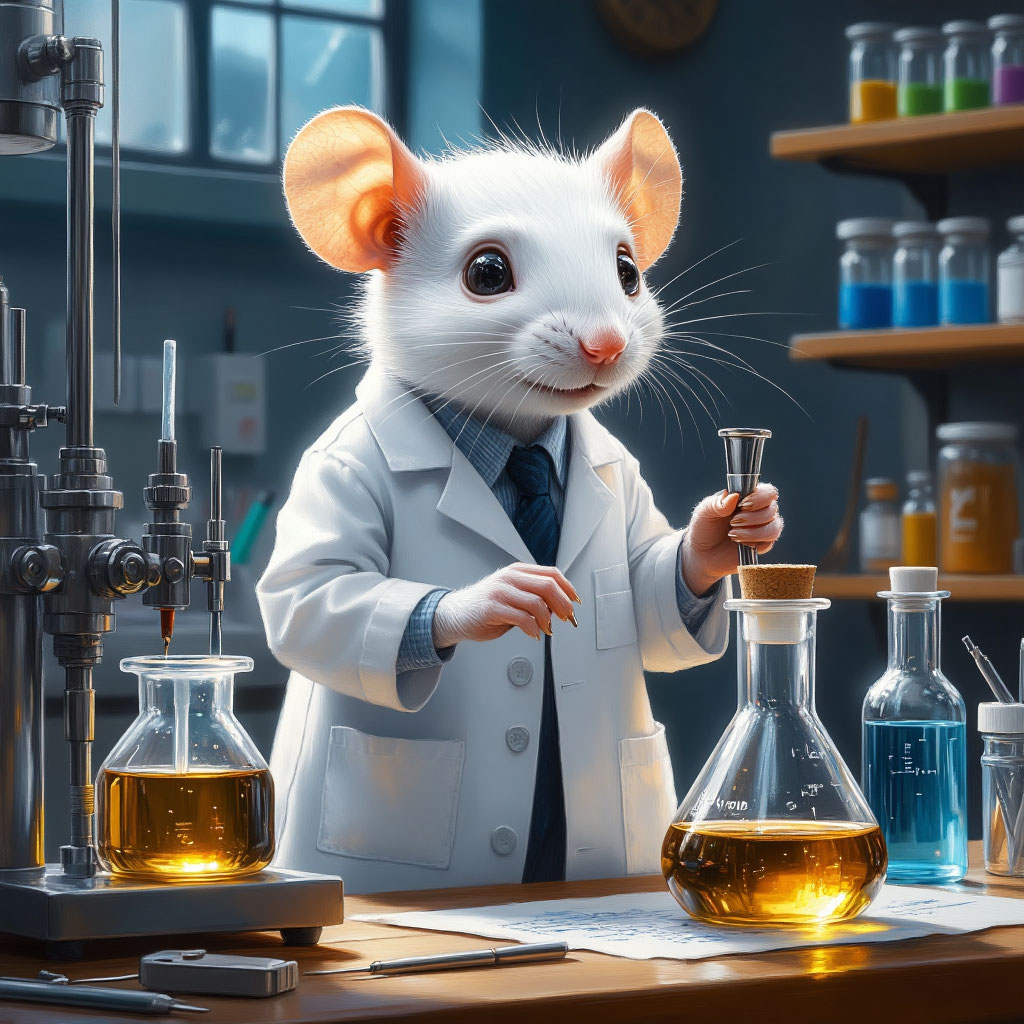

---

In [ ]:
# Подключение к базе данных Диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/tmp/ipython-input-2575294830.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(url, parse_dates=['Local_Time'])


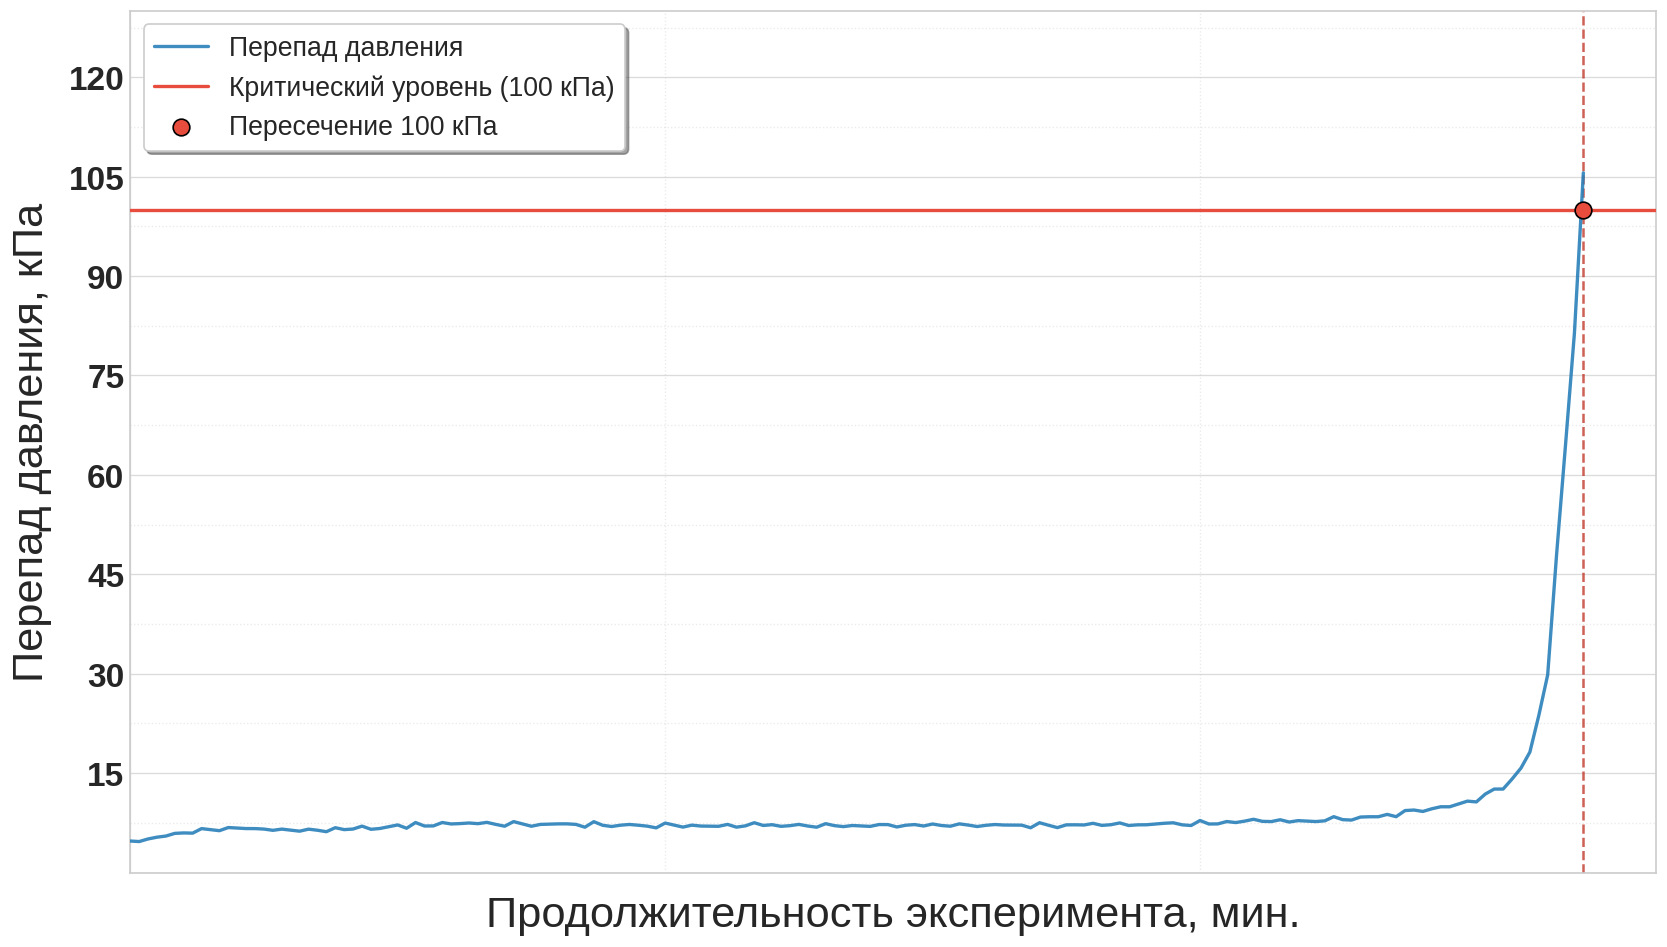

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime
import numpy as np

# Загрузка данных
url = '/VOLTES SCALE 200 образец 2 8340 (1) 6,5 на 1 г л при 110С.csv' # Сюда вставить путь с гугл диска к файлу с даннымы измерения
df = pd.read_csv(url, parse_dates=['Local_Time'])

# Преобразование времени в минуты от начала наблюдений
start_time = df['Local_Time'].iloc[0]
df['Time_min'] = (df['Local_Time'] - start_time).dt.total_seconds() / 60
df['dP_kPa'] = df['dP']  # Для явного указания единиц измерения

# Настройка стиля
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8), dpi=120)
ax = plt.gca()

# Построение основного графика
plt.plot(df['Time_min'], df['dP_kPa'],
         color='#2980b9', # Цвет линии графика
         linewidth=2.0,
         alpha=0.9,
         label='Перепад давления',
         zorder=20)

# 1. Красная линия завершения эксперимента (100 кПа)
plt.axhline(y=100, color='#e74c3c', linewidth=2.0, linestyle='-',
            label='Критический уровень (100 кПа)', zorder=12)

# 2. Поиск пиков и впадин для выделения областей
df['dP_diff'] = df['dP_kPa'].diff()

# Выделение резких скачков вверх (≥10 кПа)
#surges = df[df['dP_diff'] >= 5]
#for idx, row in surges.iterrows():
#    if idx > 0:
#        prev_time = df.at[idx-1, 'Time_min']
#        surge_duration = min(0.5, (row['Time_min'] - prev_time))  # Ограничиваем ширину области
#        plt.axvspan(prev_time, row['Time_min'],
#                   alpha=0.25,
#                   color='#f39c12',
#                   zorder=1)

# Выделение резких падений (≤-10 кПа)
#drops = df[df['dP_diff'] <= -5]
#for idx, row in drops.iterrows():
#    if idx > 0:
#        prev_time = df.at[idx-1, 'Time_min']
#        drop_duration = min(0.5, (row['Time_min'] - prev_time))
#        plt.axvspan(prev_time, row['Time_min'],
#                   alpha=0.25,
#                   color='#27ae60',
#                   zorder=1)

# 3. Выделение максимального пика
max_dp = df['dP_kPa'].max()
max_time = df.loc[df['dP_kPa'] == max_dp, 'Time_min'].values[0]
plt.axvline(max_time, color='#c0392b', linestyle='--', alpha=0.8, linewidth=1.5)

# Настройка осей и сетки
#plt.title('Состав образца 1: PAA*PMA (1:1)', fontsize=18, pad=20, fontweight='bold')
plt.xlabel('Продолжительность эксперимента, мин.', fontsize=26, labelpad=10)
plt.ylabel('Перепад давления, кПа', fontsize=26, labelpad=10)

# Настройка шрифта значений на осях X и Y
ax.tick_params(axis='x', labelsize=20)  # Ось X
ax.tick_params(axis='y', labelsize=20)  # Ось Y

# Форматирование оси X (каждые 5 минут)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.xlim(0, df['Time_min'].max() * 1.05)

# Форматирование оси Y
plt.ylim(0, max_dp * 1.15)
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

# Размер и жирность подписей делений
ax.tick_params(axis='both', labelsize=20)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_weight('bold')

def hide_zero(x, pos):
    return "" if x == 0 else f"{x:.0f}"

ax.xaxis.set_major_formatter(ticker.FuncFormatter(hide_zero))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(hide_zero))

# Добавление критических аннотаций
#plt.annotate(f'Максимум: {max_dp:.1f} кПа',
            # xy=(max_time, max_dp),
            # xytext=(max_time + 2, max_dp * 0.85),
             #arrowprops=dict(arrowstyle='->', color='#c0392b', linewidth=1.5),
             #fontsize=12,
             #color='#c0392b',
             #fontweight='bold')

# Отметка пересечения критической линии
cross_100 = df[df['dP_kPa'] >= 100]
if not cross_100.empty:
    first_cross = cross_100.iloc[0]['Time_min']
    plt.scatter(first_cross, 100, s=100, zorder=20,
                color='#e74c3c', edgecolor='black',
                label='Пересечение 100 кПа')

plt.ylim(0, 130)  # Установка максимального значения оси Y
    #plt.annotate(f'Завершение: {first_cross:.1f} мин',
                #xy=(first_cross, 100),
                #xytext=(first_cross + 2, 110),
                #arrowprops=dict(arrowstyle='->', color='#e74c3c'),
                #fontsize=11,
                #color='#e74c3c')

# Легенда и дополнительные элементы
plt.legend(fontsize=16, loc='upper left', frameon=True, shadow=True)
plt.grid(True, which='minor', linestyle=':', alpha=0.4)
plt.grid(True, which='major', linestyle='-', alpha=0.7)

# Добавление информационной панели
#stats_text = (f"▪ Длительность эксперимента: {df['Time_min'].max():.1f} мин\n"
              #f"▪ Температура испытания: 110°С")
              #f"▪ Максимальное давление: {max_dp:.1f} кПа\n"
              #f"▪ Число скачков давления: {len(surges)}\n"
              #f"▪ Число резких падений: {len(drops)}")
#plt.figtext(0.38, 0.907, stats_text,
#            fontsize=16,
#            bbox=dict(boxstyle='round', alpha=0.9, facecolor='white'))

plt.tight_layout()
plt.savefig('pressure_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#!pip list